# YOLO NAS Training - UAV

## Necessary Setup and Imports

In [1]:
# One time installation.
!pip install super-gradients==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 964.2/964.2 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 62.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB

## RESTART RUNTIME AFTER INSTALLATION IF RUNNING ON COLAB.

In [1]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

The console stream is logged into /root/sg_logs/console.log


[2023-06-12 14:39:21] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-12 14:39:33] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-12 14:39:33] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-12 14:39:33] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-12 14:39:33] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization



## Download Dataset

In [2]:
# Download dataset.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f"Downloading file")
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size, 
            unit='iB', 
            unit_scale=True
        )
        with open(os.path.join(save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print('File already present')
        
download_file(
    'https://www.dropbox.com/s/xc2890eh8ujy3cu/hituav-a-highaltitude-infrared-thermal-dataset.zip?dl=1',
    'hituav-a-highaltitude-infrared-thermal-dataset.zip'
)

  0%|          | 0.00/200M [00:00<?, ?iB/s]

In [3]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('hituav-a-highaltitude-infrared-thermal-dataset.zip')

Extracted all


## Dataset Set Up

In [ ]:
ROOT_DIR = 'hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']

In [ ]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes 
}

In [ ]:
# Global parameters.
EPOCHS = 3
BATCH_SIZE = 16
WORKERS = 8

## Visualize Ground Truth Images

In [ ]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image, 
            p1, p2, 
            color=color, 
            thickness=-1, 
            lineType=cv2.LINE_AA
        )  
        cv2.putText(
            image, 
            class_name, 
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw/3.5, 
            color=(255, 255, 255), 
            thickness=tf, 
            lineType=cv2.LINE_AA
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
        
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Extracted all


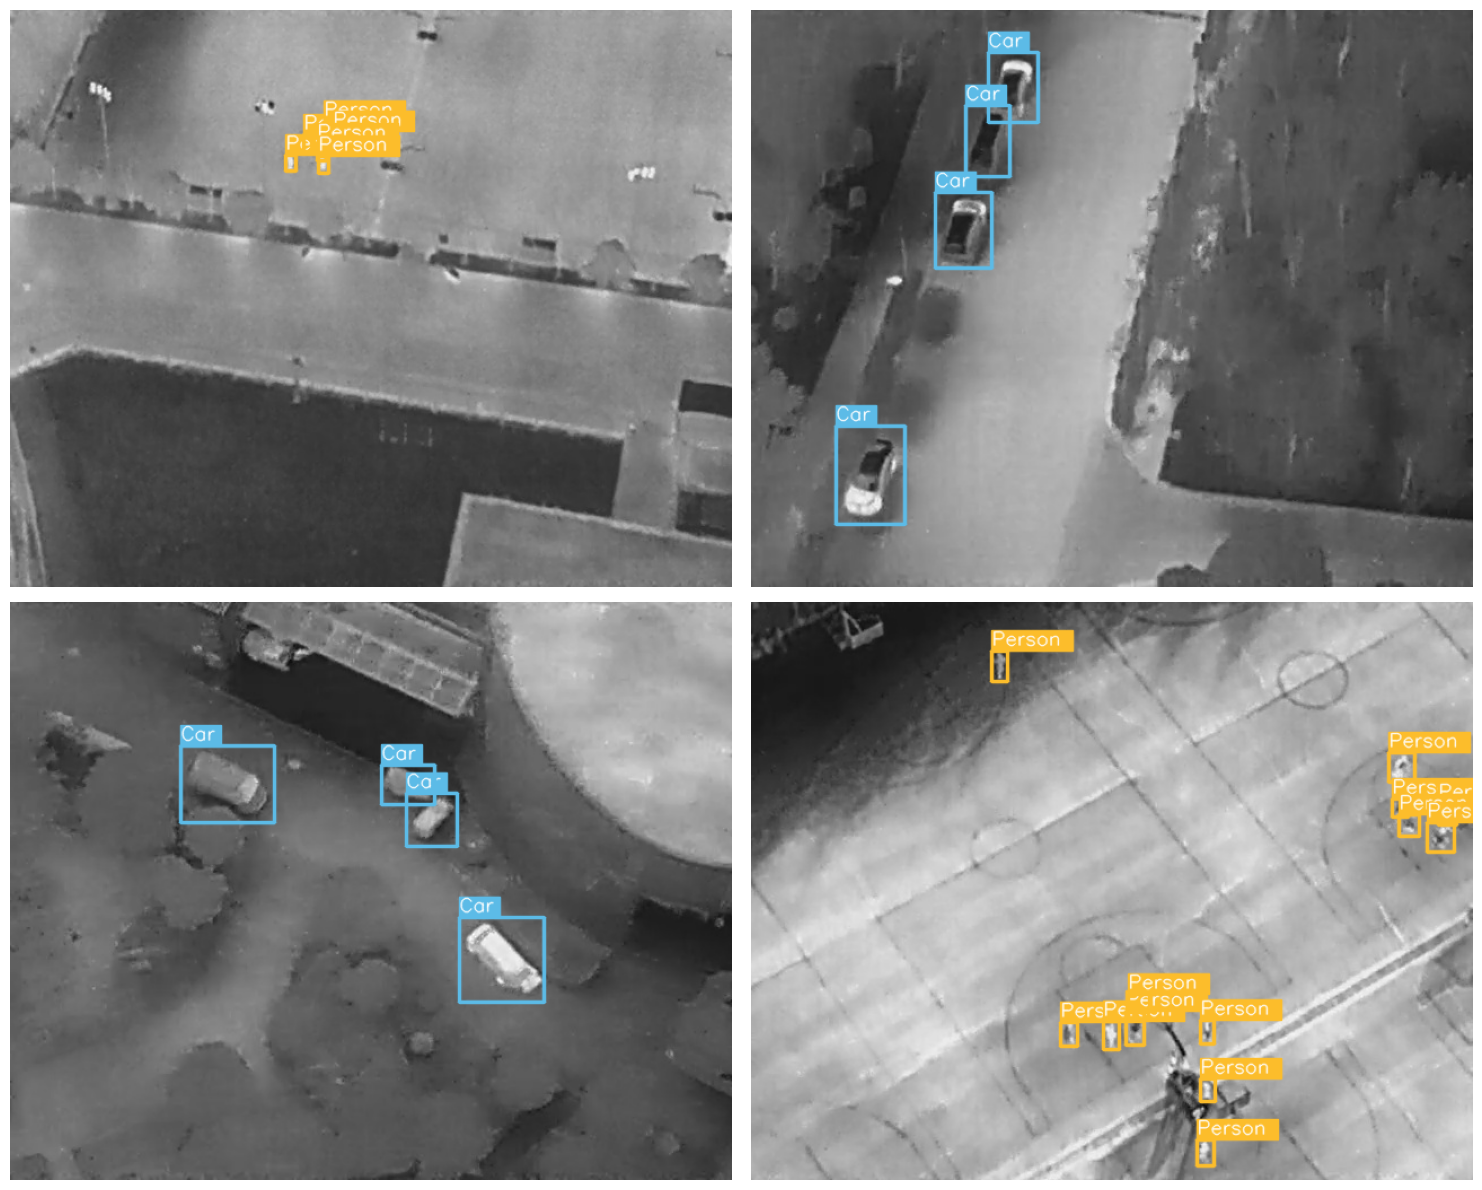

In [ ]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=4,
)

## Data Preparation

In [ ]:
import collections
collections.Iterable = collections.abc.Iterable

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

Caching annotations: 100%|██████████| 2008/2008 [00:00<00:00, 2080.87it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Transforms and Augmentations

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [ ]:
train_data.dataset.transforms[0]

DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114)

Caching annotations: 100%|██████████| 287/287 [00:00<00:00, 1902.47it/s]


In [ ]:
############ An example on how to modify augmentations ###########
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1), 'input_dim': [640, 640], 'max_targets': 120, 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDict([('bboxes', name

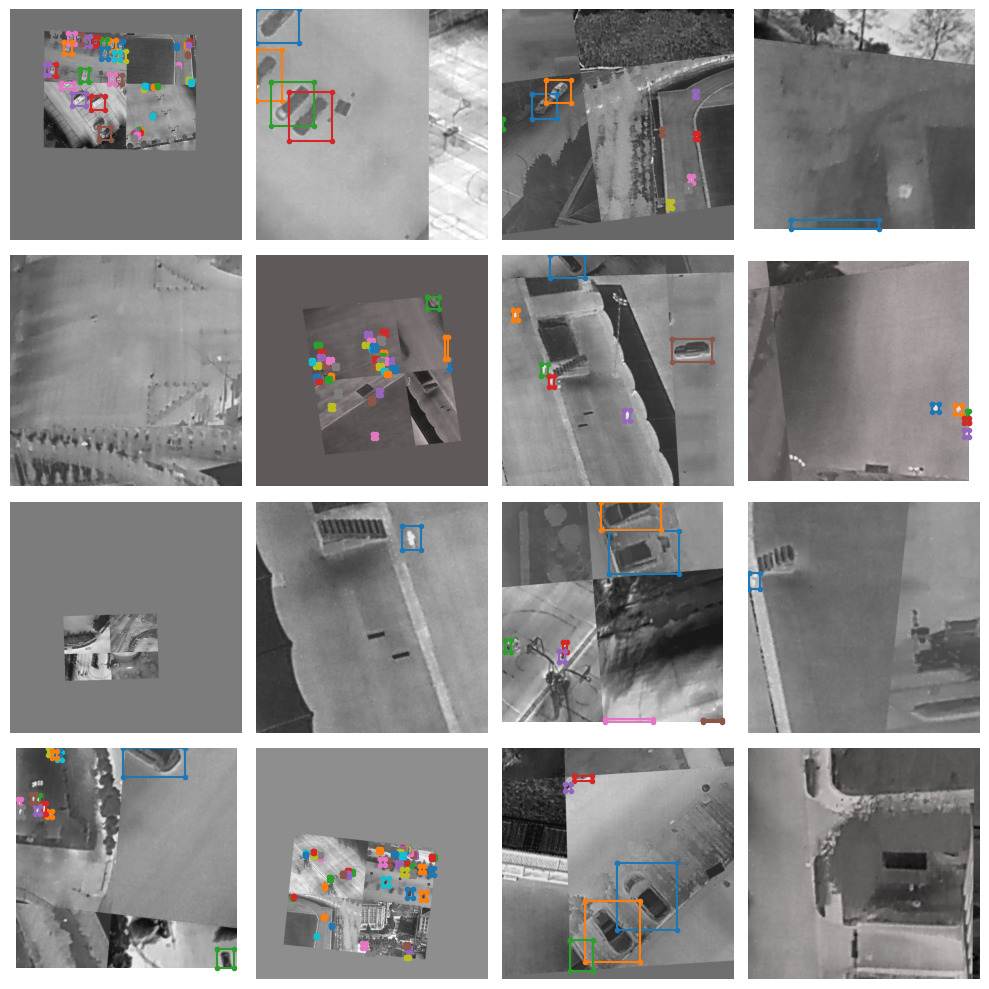

In [ ]:
# We visualize the images with augmentation here.
train_data.dataset.plot(plot_transformed_data=True)

## Prepare Model and Training Parameters

In [ ]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [ ]:
models_to_train = [
    'yolo_nas_s',
    # 'yolo_nas_m',
    # 'yolo_nas_l'
]

In [ ]:
CHECKPOINT_DIR = 'checkpoints'

### Model Training

In [ ]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train, 
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train, 
        num_classes=len(dataset_params['classes']), 
        pretrained_weights="coco"
    )

    trainer.train(
        model=model, 
        training_params=train_params, 
        train_loader=train_data, 
        valid_loader=val_data
    )

[2023-06-11 14:42:31] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


  0%|          | 0.00/73.1M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
[2023-06-11 14:42:35] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-06-11 14:42:38] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to checkpoints/yolo_nas_s/console_Jun11_14_42_39.txt


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[2023-06-11 14:42:52] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2008       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size

SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 4.0133
│   ├── Ppyoloeloss/loss_cls = 2.5385
│   ├── Ppyoloeloss/loss_dfl = 1.1695
│   └── Ppyoloeloss/loss_iou = 0.356
└── Validation
    ├── F1@0.50 = 0.0399
    ├── F1@0.50:0.95 = 0.0195
    ├── Map@0.50 = 0.0248
    ├── Map@0.50:0.95 = 0.0099
    ├── Ppyoloeloss/loss = 3.3931
    ├── Ppyoloeloss/loss_cls = 2.0946
    ├── Ppyoloeloss/loss_dfl = 1.0203
    ├── Ppyoloeloss/loss_iou = 0.3153
    ├── Precision@0.50 = 0.0444
    ├── Precision@0.50:0.95 = 0.0216
    ├── Recall@0.50 = 0.0535
    └── Recall@0.50:0.95 = 0.0263



[2023-06-11 14:44:59] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 14:44:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.0099143385887146
Validation epoch 1: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.1729
│   │   ├── Best until now = 4.0133 (↘ -1.8404)
│   │   └── Epoch N-1      = 4.0133 (↘ -1.8404)
│   ├── Ppyoloeloss/loss_cls = 1.1155
│   │   ├── Best until now = 2.5385 (↘ -1.423)
│   │   └── Epoch N-1      = 2.5385 (↘ -1.423)
│   ├── Ppyoloeloss/loss_dfl = 0.8296
│   │   ├── Best until now = 1.1695 (↘ -0.34)
│   │   └── Epoch N-1      = 1.1695 (↘ -0.34)
│   └── Ppyoloeloss/loss_iou = 0.2571
│       ├── Best until now = 0.356  (↘ -0.099)
│       └── Epoch N-1      = 0.356  (↘ -0.099)
└── Validation
    ├── F1@0.50 = 0.0736
    │   ├── Best until now = 0.0399 (↗ 0.0337)
    │   └── Epoch N-1      = 0.0399 (↗ 0.0337)
    ├── F1@0.50:0.95 = 0.0365
    │   ├── Best until now = 0.0195 (↗ 0.017)
    │   └── Epoch N-1      = 0.0195 (↗ 0.017)
    ├── Map@0.50 = 0.2769
    │   ├── Best until now = 0.0248 (↗ 0.2521)
    │   └── Epoch N-1      = 0.0248 (↗ 0.2521)
    ├── Map@0.50:0.95 = 0.1119
    │   ├── Best until now = 0.0099 (

[2023-06-11 14:47:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 14:47:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.11190887540578842
Validation epoch 2: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 1.9555
│   │   ├── Best until now = 2.1729 (↘ -0.2174)
│   │   └── Epoch N-1      = 2.1729 (↘ -0.2174)
│   ├── Ppyoloeloss/loss_cls = 0.9733
│   │   ├── Best until now = 1.1155 (↘ -0.1422)
│   │   └── Epoch N-1      = 1.1155 (↘ -0.1422)
│   ├── Ppyoloeloss/loss_dfl = 0.8053
│   │   ├── Best until now = 0.8296 (↘ -0.0243)
│   │   └── Epoch N-1      = 0.8296 (↘ -0.0243)
│   └── Ppyoloeloss/loss_iou = 0.2318
│       ├── Best until now = 0.2571 (↘ -0.0252)
│       └── Epoch N-1      = 0.2571 (↘ -0.0252)
└── Validation
    ├── F1@0.50 = 0.0809
    │   ├── Best until now = 0.0736 (↗ 0.0073)
    │   └── Epoch N-1      = 0.0736 (↗ 0.0073)
    ├── F1@0.50:0.95 = 0.0447
    │   ├── Best until now = 0.0365 (↗ 0.0081)
    │   └── Epoch N-1      = 0.0365 (↗ 0.0081)
    ├── Map@0.50 = 0.4043
    │   ├── Best until now = 0.2769 (↗ 0.1274)
    │   └── Epoch N-1      = 0.2769 (↗ 0.1274)
    ├── Map@0.50:0.95 = 0.1933
    │   ├── Best until now 

[2023-06-11 14:49:22] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 14:49:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.19330087304115295
[2023-06-11 14:49:29] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validation epoch 3: 100%|██████████| 18/18 [00:15<00:00,  1.79it/s]

# Inference

In [ ]:
import torch
import glob
import cv2
import matplotlib.pyplot as plt
import random
import os

from super_gradients.training import models
from tqdm.auto import tqdm

In [ ]:
os.makedirs('inference_results/images/', exist_ok=True)

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
model = models.get(
    model_name='yolo_nas_s',
    checkpoint_path='/content/checkpoints/yolo_nas_s/ckpt_best.pth',
    num_classes=5
).to(device)

Validation epoch 3: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s]
[2023-06-11 14:49:45] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 1.9555
│   │   ├── Best until now = 2.1729 (↘ -0.2174)
│   │   └── Epoch N-1      = 2.1729 (↘ -0.2174)
│   ├── Ppyoloeloss/loss_cls = 0.9733
│   │   ├── Best until now = 1.1155 (↘ -0.1422)
│   │   └── Epoch N-1      = 1.1155 (↘ -0.1422)
│   ├── Ppyoloeloss/loss_dfl = 0.8053
│   │   ├── Best until now = 0.8296 (↘ -0.0243)
│   │   └── Epoch N-1      = 0.8296 (↘ -0.0243)
│   └── Ppyoloeloss/loss_iou = 0.2318
│       ├── Best until now = 0.2571 (↘ -0.0252)
│       └── Epoch N-1      = 0.2571 (↘ -0.0252)
└── Validation
    ├── F1@0.50 = 0.1719
    │   ├── Best until now = 0.0809 (↗ 0.0911)
    │   └── Epoch N-1      = 0.0809 (↗ 0.0911)
    ├── F1@0.50:0.95 = 0.0969
    │   ├── Best until now = 0.0447 (↗ 0.0522)
    │   └── Epoch N-1      = 0.0447 (↗ 0.0522)
    ├── Map@0.50 = 0.3672
    │   ├── Best until now = 0.4043 (↘ -0.0371)
    │   └── Epoch N-1      = 0.4043 (↘ -0.0371)
    ├── Map@0.50:0.95 = 0.1865
    │   ├── Best until no

[2023-06-11 14:49:48] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/yolo_nas_s/ckpt_best.pth EMA checkpoint.


In [ ]:
ROOT_TEST = 'hit-uav/images/test/'
all_images = os.listdir(ROOT_TEST)

In [ ]:
for image in tqdm(all_images, total=len(all_images)):
    image_path = os.path.join(ROOT_TEST, image)
    out = model.predict(image_path)
    out.save('inference_results/images')
    os.rename(
        'inference_results/images/pred_0.jpg', 
        os.path.join('inference_results/images/', image)
    )

  0%|          | 0/571 [00:00<?, ?it/s]

In [ ]:
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color = (0, 0, 255)
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3

        cv2.rectangle(
            image, 
            (p1[0], p2[1]), new_p2, 
            color=color, 
            thickness=-1, 
            lineType=cv2.LINE_AA
        )  
        cv2.putText(
            image, 
            class_name, 
            (p1[0], p2[1] + h + 2 if outside else p2[1]),
            cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw/3, 
            color=(255, 255, 255), 
            thickness=tf, 
            lineType=cv2.LINE_AA
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
        
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.figure(figsize=(12, 9))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

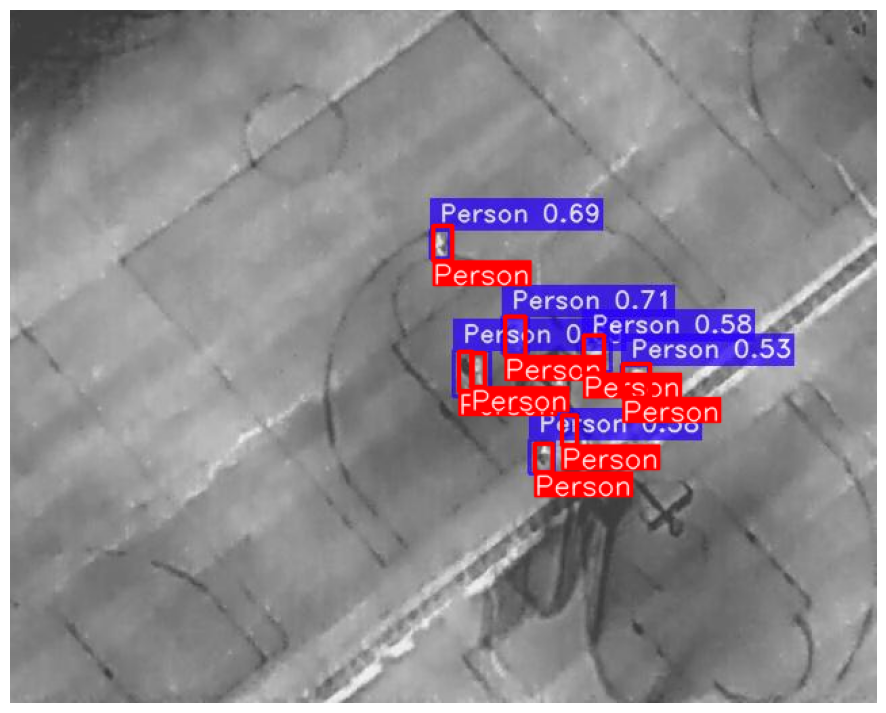

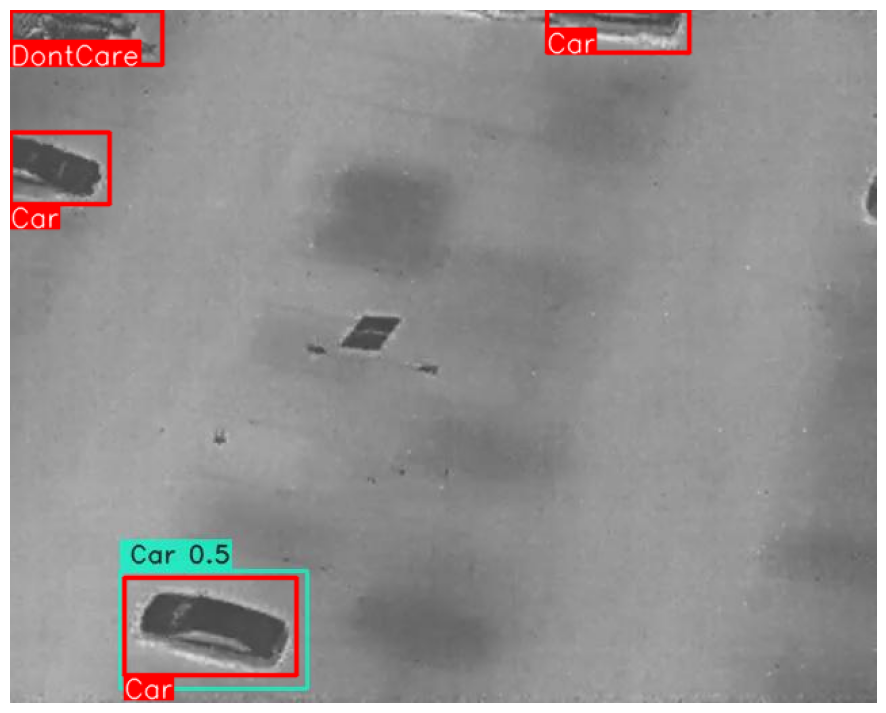

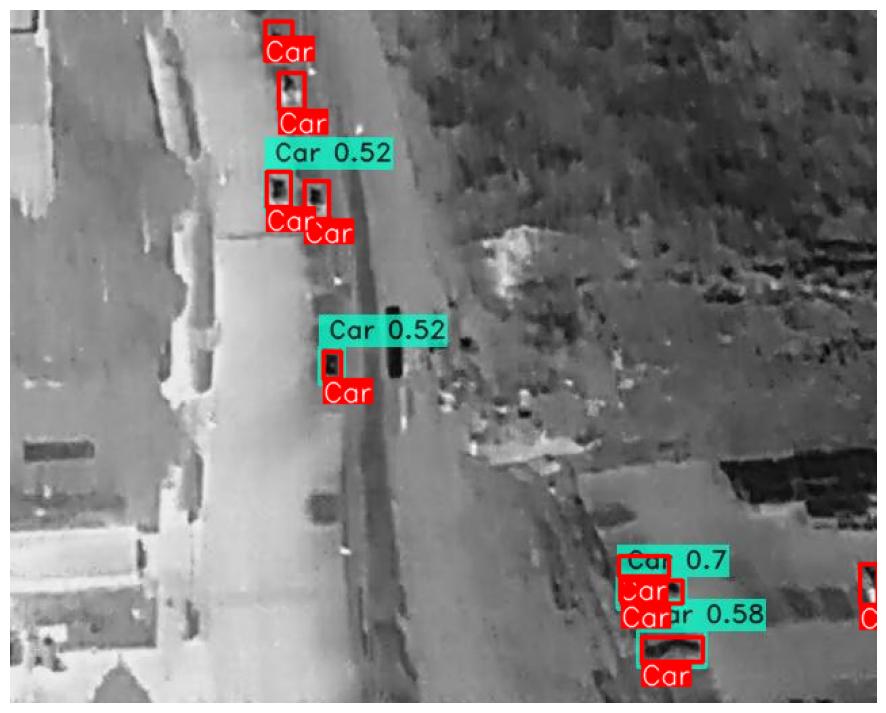

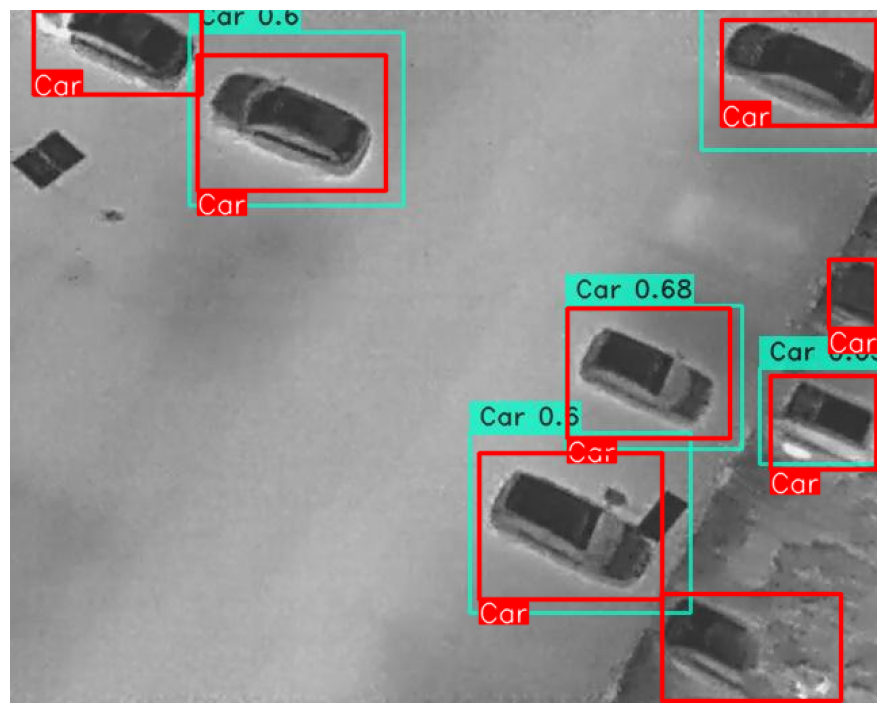

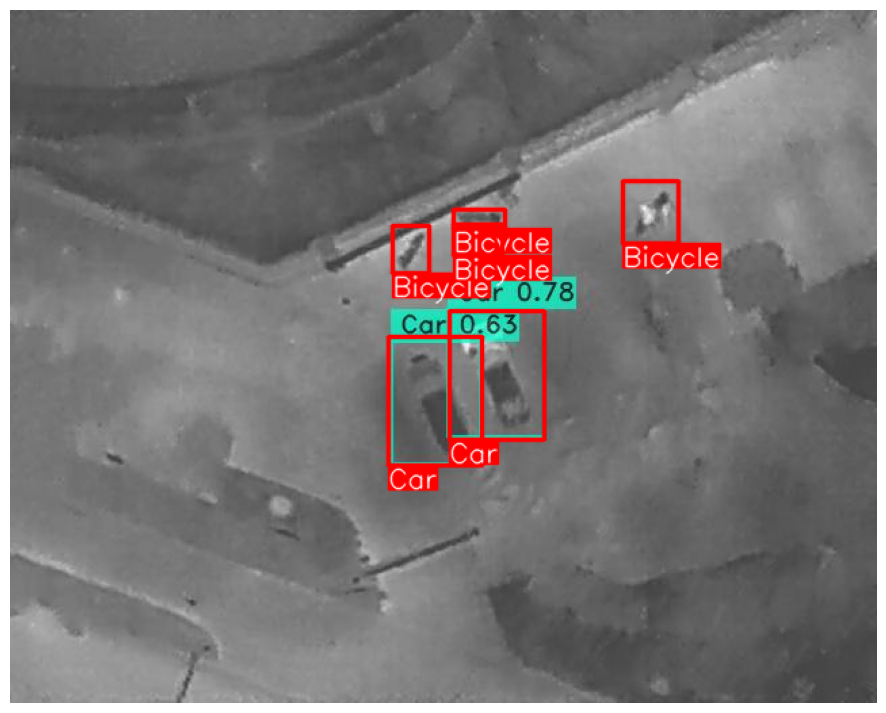

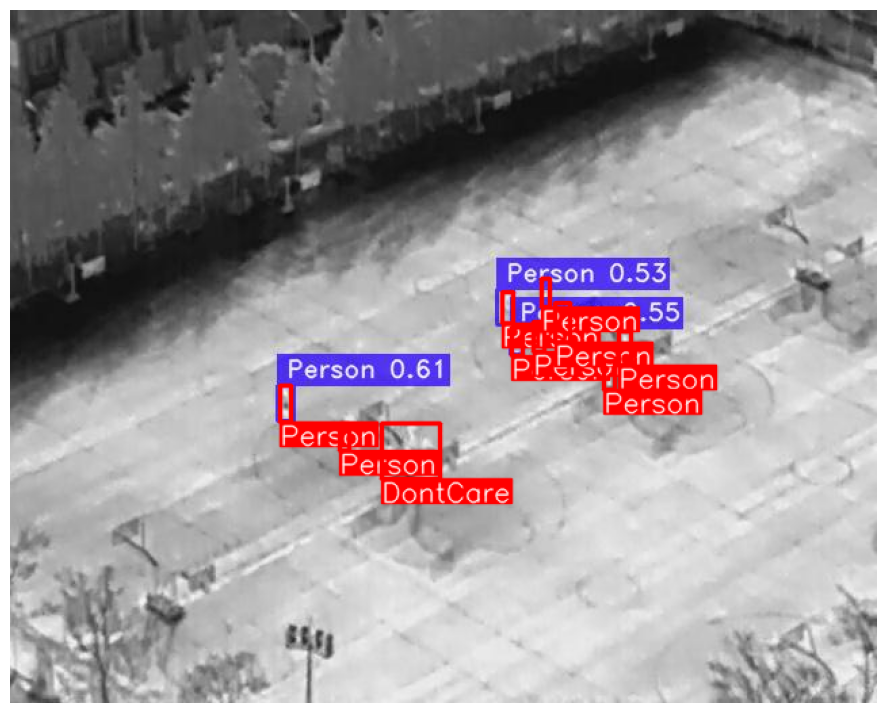

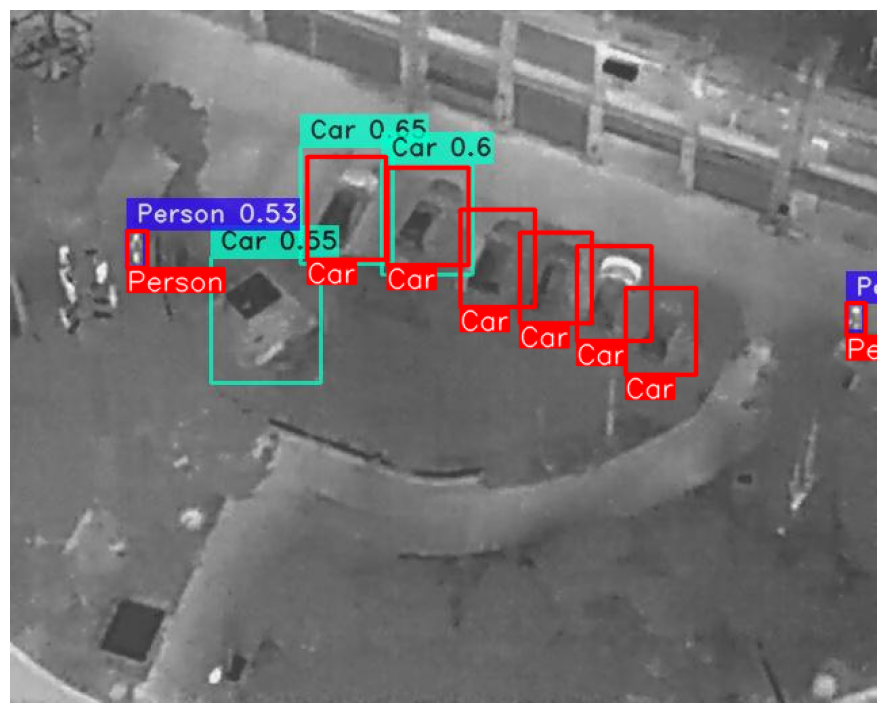

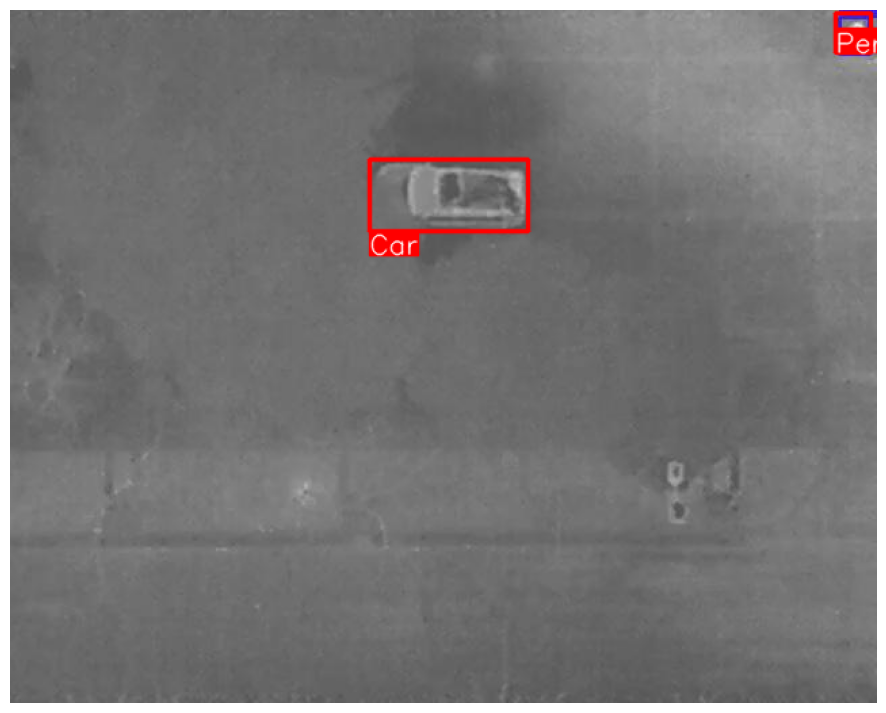

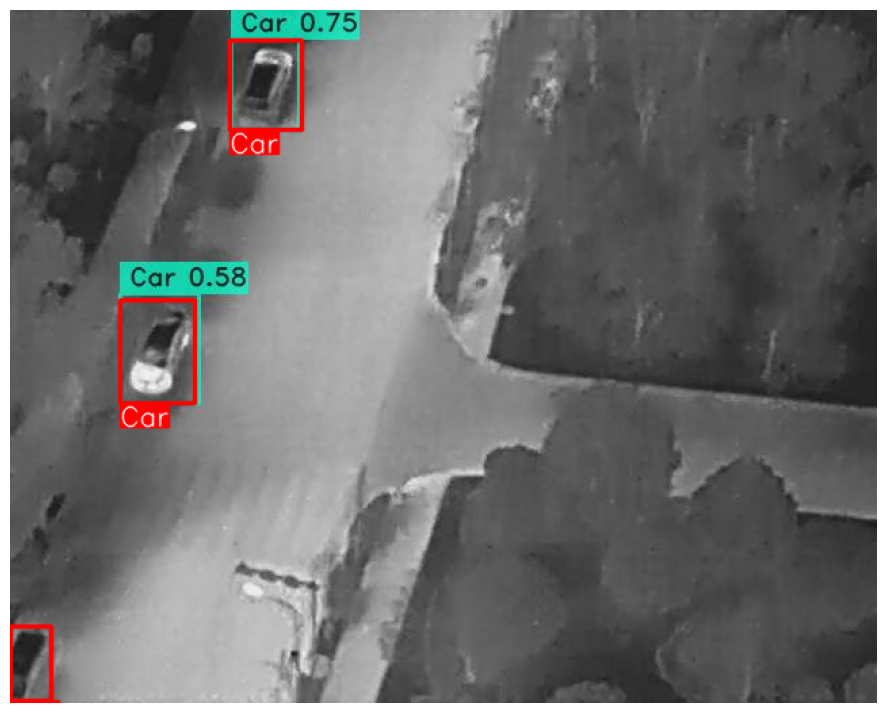

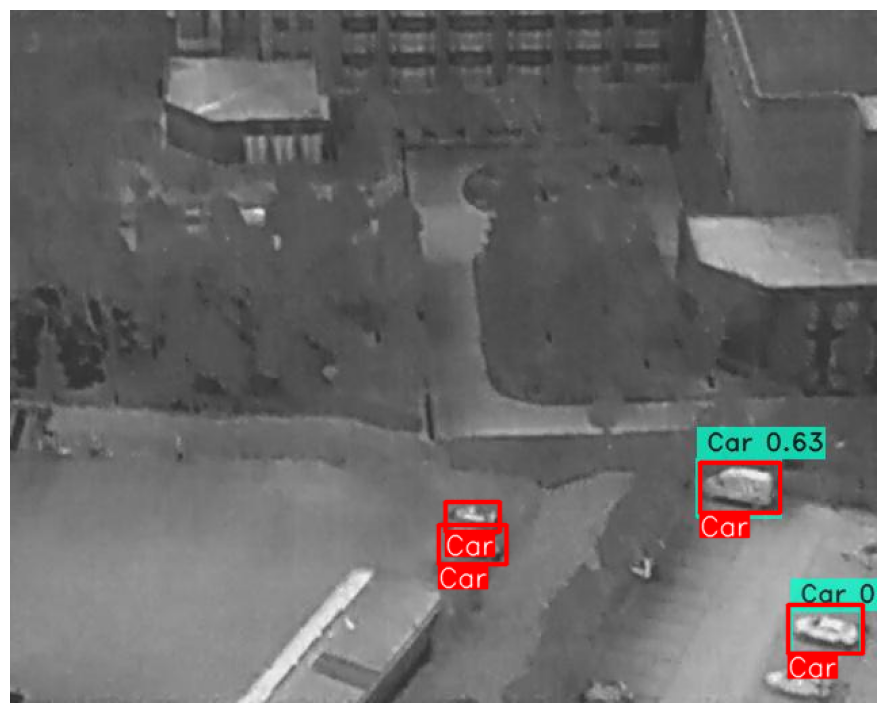

In [ ]:
# Visualize a few training images.
plot(
    image_path='inference_results/images/', 
    label_path='hit-uav/labels/test/',
    num_samples=10,
)